In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from IPython.display import Audio
import librosa
import librosa.display

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [76]:
!pip install scikit-fuzzy

  Using cached scikit_fuzzy-0.5.0-py2.py3-none-any.whl.metadata (2.6 kB)
Using cached scikit_fuzzy-0.5.0-py2.py3-none-any.whl (920 kB)


In [88]:
!pip install librosa scikit-fuzzy

In [78]:
import skfuzzy as fuzz
import skfuzzy.control as ctrl

#### Data Preparation

In [3]:
data_dir = r"C:\Users\premi\Downloads\TESS Toronto emotional speech set data"

In [5]:
# Initialize empty lists for features and labels
features = []
labels = []
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        emotion_label = folder.split('_')[-1]  # Extract the emotion label from the folder name
        
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if file_path.endswith('.wav'):
                # Load the audio file and extract features
                audio, sr = librosa.load(file_path, duration=3)  # Adjust the duration as needed
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
                mfcc_mean = np.mean(mfcc, axis=1)
                features.append(mfcc_mean)
                labels.append(emotion_label)

In [7]:
features = np.array(features)
labels = np.array(labels)

In [64]:
# Encode the emotion labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [11]:
# Define the emotions and the number of samples to select from each emotion
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
num_samples_per_emotion = 3
# Initialize empty lists for storing the selected samples
selected_samples = []

In [13]:
# Iterate through the emotions and select samples
for emotion in emotions:
    emotion_dir = os.path.join(data_dir, f'OAF_{emotion}')
    audio_files = os.listdir(emotion_dir)
    selected_files = np.random.choice(audio_files, size=num_samples_per_emotion, replace=False)
    
    for file_name in selected_files:
        file_path = os.path.join(emotion_dir, file_name)
        audio, sr = librosa.load(file_path, duration=3)
        selected_samples.append((audio, sr, emotion))

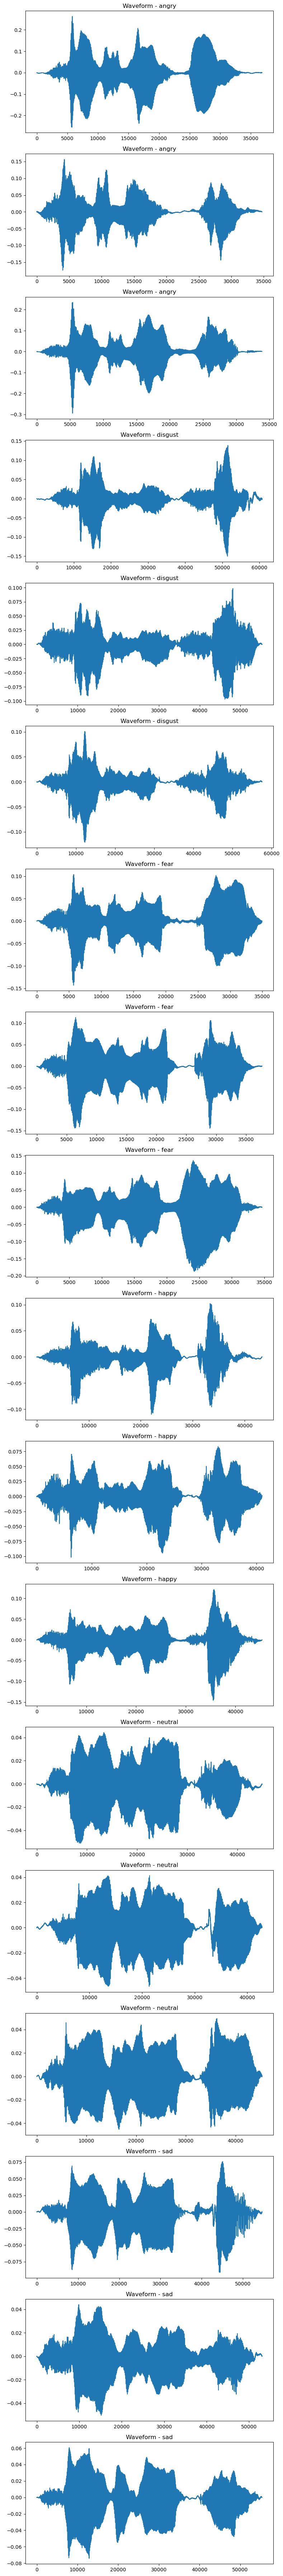

In [15]:
# Plot the selected samples
num_samples = len(selected_samples)
plt.figure(figsize=(8, 4 * num_samples))

for i, (audio, sr, emotion) in enumerate(selected_samples):
    plt.subplot(num_samples, 1, i + 1)
    plt.plot(audio)
    plt.title(f'Waveform - {emotion}')

plt.tight_layout()
plt.show()

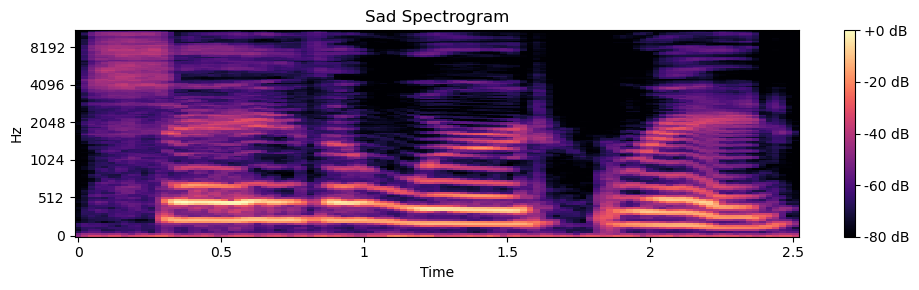

In [19]:
# Calculate the spectrogram
spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)

# Convert power spectrogram to dB scale
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 3))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Sad Spectrogram')
plt.tight_layout()
plt.show()
Audio(file_path)

#### Augmentation
Include data augmentation techniques after basic data preparation.

In [21]:
# Assuming features and labels are already defined
augmented_features = []
augmented_labels = []

# Define the target length for padding/truncation (e.g., based on the longest feature)
target_length = max(len(feature) for feature in features)  # Or you can set a fixed value

def pad_or_truncate(audio, target_length):
    if len(audio) < target_length:
        # Pad with zeros if shorter
        return np.pad(audio, (0, target_length - len(audio)), 'constant')
    elif len(audio) > target_length:
        # Truncate if longer
        return audio[:target_length]
    return audio

# Apply transformations to the features
for feature, label in zip(features, labels):
    augmented_features.append(pad_or_truncate(feature, target_length))
    augmented_labels.append(label)
    
    # Apply noise addition
    noise = np.random.randn(len(feature))
    augmented_features.append(pad_or_truncate(feature + 0.005 * noise, target_length))  # Adjust the noise magnitude as needed
    augmented_labels.append(label)
    
    # Apply time stretching
    augmented_features.append(pad_or_truncate(librosa.effects.time_stretch(feature, rate=1.2), target_length))  # Adjust the rate as needed
    augmented_labels.append(label)
    
    # Apply pitch shifting 
    augmented_features.append(pad_or_truncate(librosa.effects.pitch_shift(feature, sr=22050, n_steps=0.7), target_length))  
    augmented_labels.append(label)

# Convert the augmented lists to NumPy arrays
augmented_features = np.array(augmented_features)
augmented_labels = np.array(augmented_labels)

# Print the number of original and augmented samples
print('Original samples:', len(features))
print('Augmented samples:', len(augmented_features))

Original samples: 2800
Augmented samples: 11200


In [23]:
# Define a list to store the preprocessed data
preprocessed_data = []
file_list = os.listdir(data_dir)
# Iterate over the files
for filename in file_list:
    file_path = os.path.join(data_dir, filename)
    
    # Skip non-audio files
    if not filename.endswith('.wav'):
        continue

    # Load the audio file and obtain the waveform and sample rate
    waveform, sr = librosa.load(file_path, sr=None, dtype=np.float32)

    # Resample the audio if needed
    if sr != 22050:
        waveform = librosa.resample(waveform, sr, 22050)
        sr = 22050

In [25]:
# Encode the emotion labels
label_mapping = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}
encoded_labels = np.array([label_mapping.get(label, -1) for label in labels])

# Filter out any samples with unknown emotion labels
valid_indices = np.where(encoded_labels != 1)[0]  # Get the indices from the tuple
features = features[valid_indices]
encoded_labels = encoded_labels[valid_indices]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# Reshape the input features
X_train = X_train.reshape((*X_train.shape, 1))
X_test = X_test.reshape((*X_test.shape, 1))


# Convert the emotion labels to categorical format
num_classes = len(label_mapping)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [27]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1920, 13, 1)
y_train shape: (1920, 6)
X_test shape: (480, 13, 1)
y_test shape: (480, 6)


In [37]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=6, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 13, 256)        │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 7, 256)         │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 4, 128)         │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 2, 64)          │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536,742 (2.05 MB)

 Trainable params: 536,742 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

#### Model Training
Train the model and track its performance

In [45]:
history=model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test), batch_size=64)

Epoch 1/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9030 - loss: 0.2519 - val_accuracy: 0.9062 - val_loss: 0.2329
Epoch 2/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9193 - loss: 0.2092 - val_accuracy: 0.8938 - val_loss: 0.2446
Epoch 3/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9126 - loss: 0.2254 - val_accuracy: 0.9208 - val_loss: 0.2679
Epoch 4/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9140 - loss: 0.2107 - val_accuracy: 0.9062 - val_loss: 0.2956
Epoch 5/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9322 - loss: 0.1782 - val_accuracy: 0.9083 - val_loss: 0.2221
Epoch 6/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9144 - loss: 0.1915 - val_accuracy: 0.9062 - val_loss: 0.2477
Epoch 7/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9164 - loss: 0.2014 - val_accuracy: 0.8813 - val_loss: 0.2914
Epoch 8/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9108 - loss: 0.2007 - val_accuracy: 0.9375 - v

#### Evaluate the Model
Evaluate the model's performance on test data.

In [47]:
loss, accuracy = model.evaluate(X_test, y_test)

print("Test loss:", loss)
print("Test accuracy:", accuracy)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9436 - loss: 0.2313
Test loss: 0.2672569453716278
Test accuracy: 0.9354166388511658


In [49]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9436 - loss: 0.2313
Accuracy of our model on test data :  93.54166388511658 %


#### Visualize Training Results
Plot the accuracy and loss over epochs.

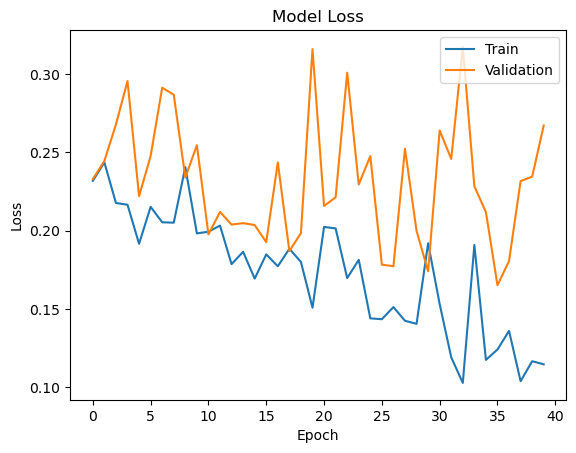

In [51]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

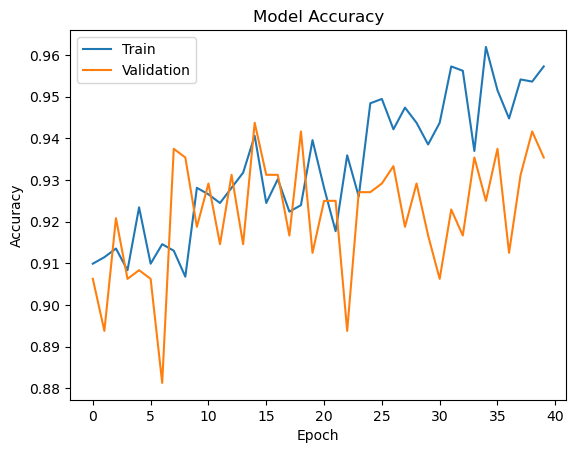

In [53]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Generate Predictions and Metrics
Generate confusion matrices and classification reports.

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


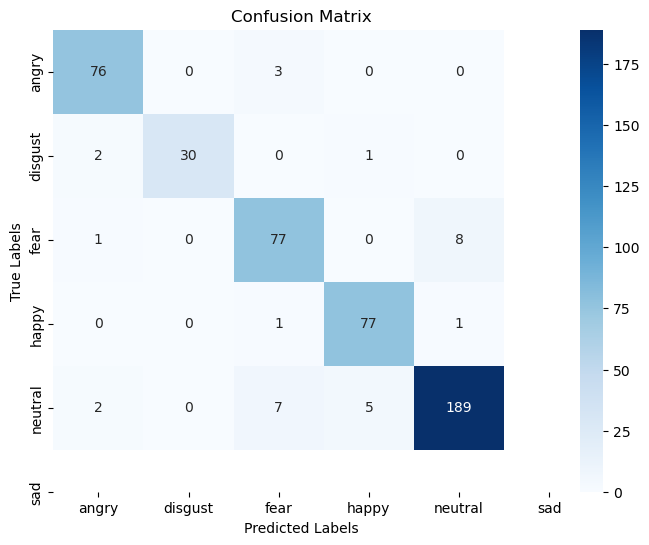

In [55]:
# Get the predicted labels for the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions to labels

# Convert the true labels from one-hot encoding to labels
y_true_labels = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']  # Replace with your actual class names
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, labels=range(len(class_names)))

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [57]:
print(report)

              precision    recall  f1-score   support

       angry       0.94      0.96      0.95        79
     disgust       0.00      0.00      0.00         0
        fear       1.00      0.91      0.95        33
       happy       0.88      0.90      0.89        86
     neutral       0.93      0.97      0.95        79
         sad       0.95      0.93      0.94       203

   micro avg       0.94      0.94      0.94       480
   macro avg       0.78      0.78      0.78       480
weighted avg       0.94      0.94      0.94       480



In [59]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=64)

Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9547 - loss: 0.1288 - val_accuracy: 0.9323 - val_loss: 0.1401
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9419 - loss: 0.1401 - val_accuracy: 0.9514 - val_loss: 0.1146
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9641 - loss: 0.1003 - val_accuracy: 0.9479 - val_loss: 0.1329
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9670 - loss: 0.0876 - val_accuracy: 0.9514 - val_loss: 0.1220
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9668 - loss: 0.0935 - val_accuracy: 0.9340 - val_loss: 0.1421
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9340 - loss: 0.1496 - val_accuracy: 0.9497 - val_loss: 0.1430
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9499 - loss: 0.1621 - val_accuracy: 0.9132 - val_loss: 0.1903
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9511 - loss: 0.1285 - val_accuracy: 0.9444 - v

In [61]:
print("Accuracy of our model on train data : " , model.evaluate(X_train,y_train)[1]*100 , "%")

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9810 - loss: 0.0502
Accuracy of our model on train data :  97.29166626930237 %


In [104]:
import librosa
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Fuzzy logic setup
def setup_fuzzy_system():
    # Create fuzzy variables for MFCC Mean and MFCC Variance
    mfcc_mean = ctrl.Antecedent(np.arange(0, 101, 1), 'mfcc_mean')
    mfcc_variance = ctrl.Antecedent(np.arange(0, 51, 1), 'mfcc_variance')
    emotion = ctrl.Consequent(np.arange(0, 7, 1), 'emotion')

    # Define membership functions for MFCC Mean
    mfcc_mean['low'] = fuzz.trimf(mfcc_mean.universe, [0, 0, 40])
    mfcc_mean['medium'] = fuzz.trimf(mfcc_mean.universe, [20, 50, 80])
    mfcc_mean['high'] = fuzz.trimf(mfcc_mean.universe, [60, 100, 100])

    # Define membership functions for MFCC Variance
    mfcc_variance['low'] = fuzz.trimf(mfcc_variance.universe, [0, 0, 20])
    mfcc_variance['medium'] = fuzz.trimf(mfcc_variance.universe, [10, 30, 40])
    mfcc_variance['high'] = fuzz.trimf(mfcc_variance.universe, [30, 40, 50])

    # Define membership functions for Emotion (7 emotions)
    emotion['angry'] = fuzz.trimf(emotion.universe, [0, 0, 1])
    emotion['disgust'] = fuzz.trimf(emotion.universe, [0, 1, 2])
    emotion['fear'] = fuzz.trimf(emotion.universe, [1, 2, 3])
    emotion['happy'] = fuzz.trimf(emotion.universe, [2, 3, 4])
    emotion['neutral'] = fuzz.trimf(emotion.universe, [3, 4, 5])
    emotion['ps'] = fuzz.trimf(emotion.universe, [4, 5, 6])
    emotion['sad'] = fuzz.trimf(emotion.universe, [5, 6, 6])

    # Define fuzzy rules
    rule1 = ctrl.Rule(mfcc_mean['low'] & mfcc_variance['low'], emotion['sad'])
    rule2 = ctrl.Rule(mfcc_mean['low'] & mfcc_variance['medium'], emotion['angry'])
    rule3 = ctrl.Rule(mfcc_mean['low'] & mfcc_variance['high'], emotion['disgust'])
    rule4 = ctrl.Rule(mfcc_mean['medium'] & mfcc_variance['low'], emotion['sad'])
    rule5 = ctrl.Rule(mfcc_mean['medium'] & mfcc_variance['medium'], emotion['neutral'])
    rule6 = ctrl.Rule(mfcc_mean['medium'] & mfcc_variance['high'], emotion['fear'])
    rule7 = ctrl.Rule(mfcc_mean['high'] & mfcc_variance['low'], emotion['ps'])
    rule8 = ctrl.Rule(mfcc_mean['high'] & mfcc_variance['medium'], emotion['happy'])
    rule9 = ctrl.Rule(mfcc_mean['high'] & mfcc_variance['high'], emotion['fear'])

    # Create the control system
    emotion_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
    emotion_simulation = ctrl.ControlSystemSimulation(emotion_ctrl)

    return emotion_simulation, mfcc_mean, mfcc_variance

# Function to extract MFCC features from an audio file
def extract_mfcc_features(audio_file):
    # Load the audio file
    y, sr = librosa.load(audio_file, sr=None)
    
    # Extract MFCCs (using 13 coefficients)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    
    # Compute the mean and variance of the MFCC coefficients
    mfcc_mean = np.mean(mfcc)
    mfcc_variance = np.var(mfcc)
    
    # Normalize the MFCC values to fall within the expected fuzzy system ranges
    normalized_mfcc_mean = np.clip((mfcc_mean + 50) / 2, 0, 100)  # Scaling and clipping
    normalized_mfcc_variance = np.clip(mfcc_variance / 1000, 0, 50)  # Scaling and clipping
    
    return normalized_mfcc_mean, normalized_mfcc_variance

# Main function to predict emotion
def predict_emotion(audio_file):
    # Extract MFCC mean and variance from the audio file
    mfcc_mean, mfcc_variance = extract_mfcc_features(audio_file)

    # Print the extracted MFCC features for debugging
    print(f"Normalized MFCC Mean: {mfcc_mean}, Normalized MFCC Variance: {mfcc_variance}")

    # Setup fuzzy logic system
    emotion_simulation, mfcc_mean_var, mfcc_variance_var = setup_fuzzy_system()

    # Input the MFCC features into the fuzzy system
    emotion_simulation.input['mfcc_mean'] = mfcc_mean
    emotion_simulation.input['mfcc_variance'] = mfcc_variance

    # Compute the output of the fuzzy system
    emotion_simulation.compute()

    # Print the computed fuzzy output for debugging
    print(f"Fuzzy Output: {emotion_simulation.output}")

    # Check if the 'emotion' output is available and return the predicted emotion
    if 'emotion' in emotion_simulation.output:
        return emotion_simulation.output['emotion']
    else:
        print("Error: No output for 'emotion'")
        return None

# Test the system with the provided audio file path
audio_file = r"C:\Users\premi\Downloads\TESS Toronto emotional speech set data\OAF_happy\OAF_witch_happy.wav"  # Provide the path to your audio file
predicted_emotion = predict_emotion(audio_file)

# Map the fuzzy output to the corresponding emotion
if predicted_emotion is not None:
    emotion_map = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Neutral", 5: "PS (Positive Surprise)", 6: "Sad"}
    predicted_emotion_label = emotion_map[int(round(predicted_emotion))]
    print(f"Predicted Emotion: {predicted_emotion_label}")
else:
    print("Emotion prediction failed.")

Normalized MFCC Mean: 9.94470500946045, Normalized MFCC Variance: 15.943619140625
Fuzzy Output: {'emotion': 2.573280215238112}
Predicted Emotion: Happy
